In [1]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [2]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf

# Image size and labels
IMAGE_SIZE = 150
LABELS = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Dataset paths
BASE_DIR = '../mri all'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
VAL_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR = os.path.join(BASE_DIR, 'Testing')

In [4]:
# ✅ Add MRI preprocessing function
def mri_preprocessing(image):
    """Enhanced MRI-specific preprocessing"""
    # Convert to grayscale if needed (handles both color and grayscale inputs)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    
    # Contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Noise reduction
    blurred = cv2.medianBlur(enhanced, 3)
    
    # Resize and normalize
    processed = cv2.resize(blurred, (IMAGE_SIZE, IMAGE_SIZE))
    return np.expand_dims(processed/255.0, axis=-1)  # Add channel dimension

In [5]:
def load_data(directory):
    X, Y = [], []
    for label in LABELS:
        folder_path = os.path.join(directory, label)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)  # Handle varied inputs
            if img is not None:
                # Single preprocessing call handles all transformations
                processed = mri_preprocessing(img)
                X.append(processed)
                Y.append(label)
    return np.array(X), np.array(Y)

In [6]:
X_train, Y_train = load_data(TRAIN_DIR)
X_val, Y_val = load_data(VAL_DIR)
X_test, Y_test = load_data(TEST_DIR)


In [7]:
def encode_labels(Y):
    return tf.keras.utils.to_categorical([LABELS.index(y) for y in Y], num_classes=len(LABELS))

Y_train, Y_val, Y_test = encode_labels(Y_train), encode_labels(Y_val), encode_labels(Y_test)

In [8]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=101)

In [9]:
def print_shapes():
    print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
    print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
    print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

print_shapes()

X_train: (4855, 150, 150, 1), Y_train: (4855, 4)
X_val: (1277, 150, 150, 1), Y_val: (1277, 4)
X_test: (787, 150, 150, 1), Y_test: (787, 4)


In [10]:
def count_images(directory):
    return {label: len(os.listdir(os.path.join(directory, label))) for label in LABELS}

train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

In [11]:
def print_counts(counts, dataset_name):
    print(f"\n{dataset_name} Dataset Distribution:")
    for label, count in counts.items():
        print(f"{label}: {count} images")

print_counts(train_counts, "Training")
print_counts(val_counts, "Validation")
print_counts(test_counts, "Testing")


Training Dataset Distribution:
glioma_tumor: 1629 images
meningioma_tumor: 733 images
no_tumor: 1217 images
pituitary_tumor: 1276 images

Validation Dataset Distribution:
glioma_tumor: 433 images
meningioma_tumor: 201 images
no_tumor: 322 images
pituitary_tumor: 321 images

Testing Dataset Distribution:
glioma_tumor: 266 images
meningioma_tumor: 153 images
no_tumor: 189 images
pituitary_tumor: 179 images


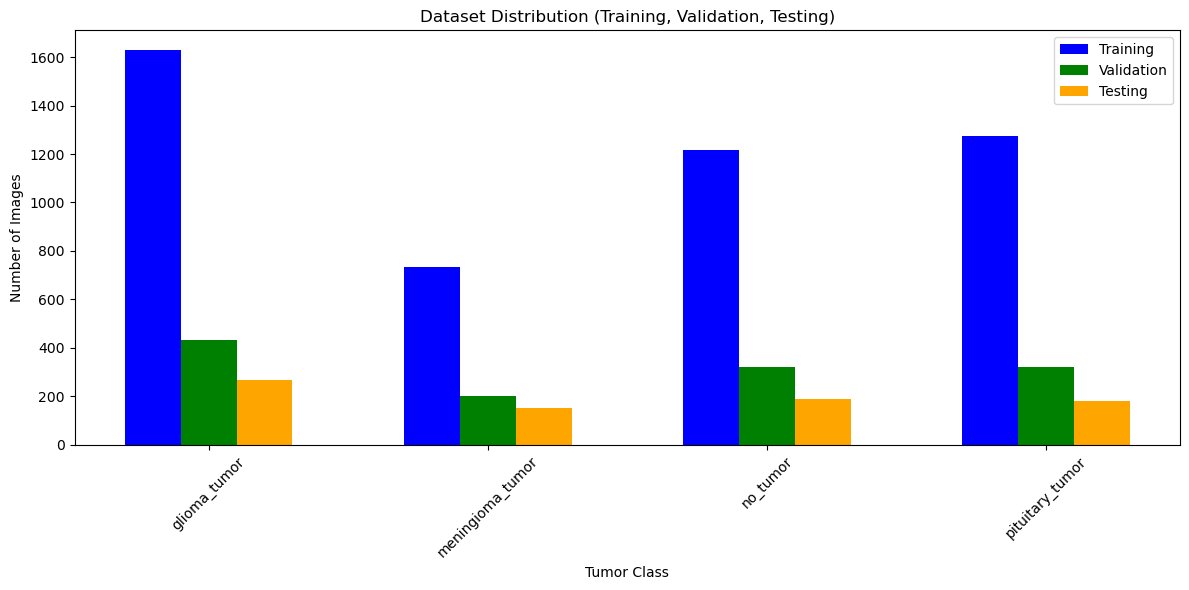

In [12]:
def plot_dataset_distribution():
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.2
    x = np.arange(len(LABELS))

    ax.bar(x - width, list(train_counts.values()), width, label="Training", color="blue")
    ax.bar(x, list(val_counts.values()), width, label="Validation", color="green")
    ax.bar(x + width, list(test_counts.values()), width, label="Testing", color="orange")

    ax.set_xlabel("Tumor Class")
    ax.set_ylabel("Number of Images")
    ax.set_title("Dataset Distribution (Training, Validation, Testing)")
    ax.set_xticks(x)
    ax.set_xticklabels(LABELS)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_dataset_distribution()


Sample Images from Training Dataset:


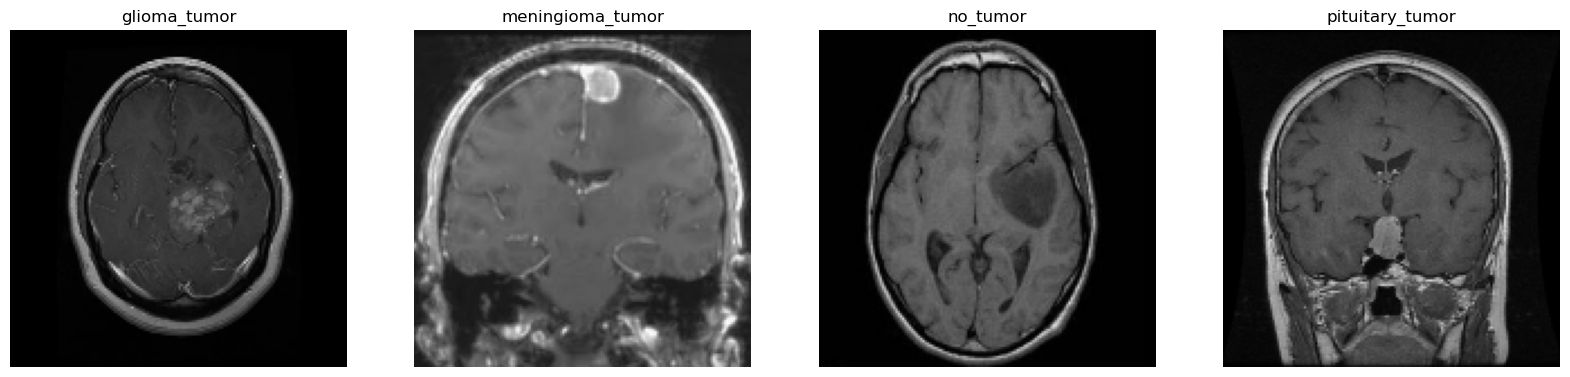


Sample Images from Validation Dataset:


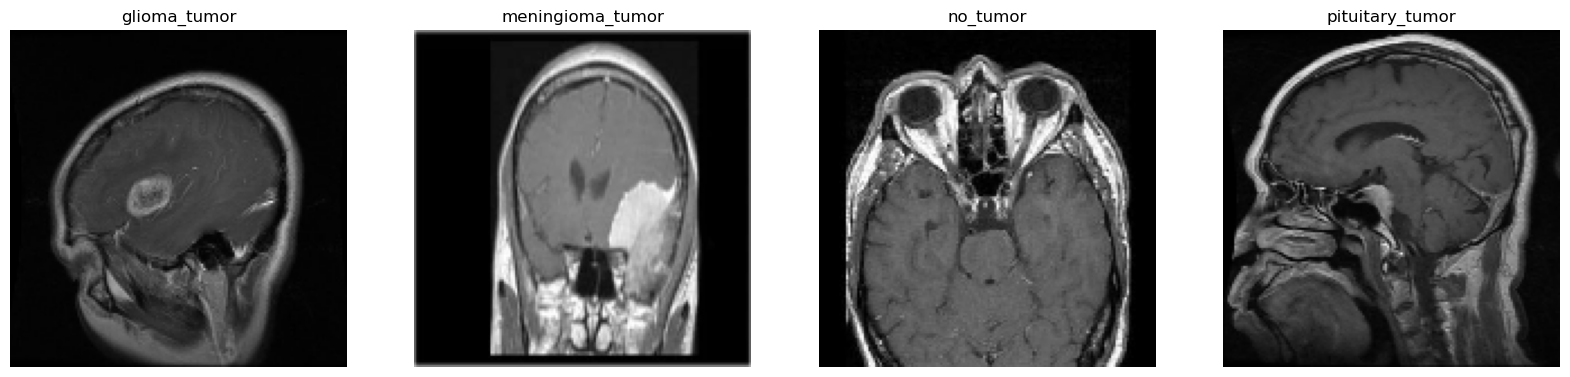


Sample Images from Testing Dataset:


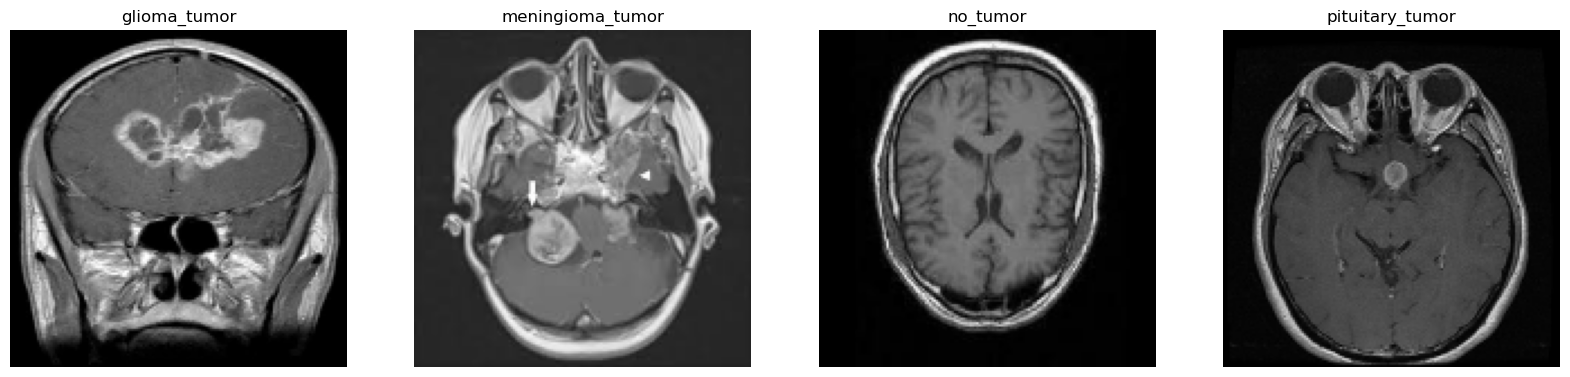

In [13]:
def display_sample_images(directory, dataset_name):
    fig, axes = plt.subplots(1, len(LABELS), figsize=(20, 5))
    for i, label in enumerate(LABELS):
        folder_path = os.path.join(directory, label)
        sample_img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        img = cv2.imread(sample_img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        axes[i].imshow(img)
        axes[i].set_title(label)
        axes[i].axis("off")
    plt.show()

print("\nSample Images from Training Dataset:")
display_sample_images(TRAIN_DIR, "Training")

print("\nSample Images from Validation Dataset:")
display_sample_images(VAL_DIR, "Validation")

print("\nSample Images from Testing Dataset:")
display_sample_images(TEST_DIR, "Testing")

In [14]:
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to class indices
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 0.7450890116635973, 1: 1.6558663028649385, 2: 0.997329498767461, 3: 0.9512147335423198}


In [15]:
from tensorflow import keras
from tensorflow.keras import regularizers

my_model = keras.models.Sequential([
    # First Convolutional Block
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01), name='Conv1'),
    keras.layers.BatchNormalization(name='BatchNormalization1'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling1'),
    
    # Second Convolutional Block
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01), name='Conv2'),
    keras.layers.BatchNormalization(name='BatchNormalization2'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling2'),
    
    # Third Convolutional Block
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01), name='Conv3'),
    keras.layers.BatchNormalization(name='BatchNormalization3'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling3'),
    
    # Fourth Convolutional Block
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01), name='Conv4'),
    keras.layers.BatchNormalization(name='BatchNormalization4'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling4'),

    # Fifth Convolutional Block
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', 
                        kernel_regularizer=regularizers.l2(0.01), name='Conv5'),
    keras.layers.BatchNormalization(name='BatchNormalization5'),
    keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling5'),
    
    # Flatten Layer
    keras.layers.Flatten(name='Flatten'),
    
    # Dense Layers with Dropout and L2 Regularization
    keras.layers.Dense(512, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01), name='Dense1'),  # Increased units to capture more features
    keras.layers.Dropout(0.5, name='Dropout1'),  # Increased Dropout for better regularization
    keras.layers.Dense(512, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01), name='Dense2'),
    keras.layers.Dropout(0.5, name='Dropout2'),
    keras.layers.Dense(256, activation='relu', 
                       kernel_regularizer=regularizers.l2(0.01), name='Dense3'),
    keras.layers.Dropout(0.5, name='Dropout3'),
    
    # Output Layer
    keras.layers.Dense(4, activation='softmax', name='Output')
])

In [15]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 BatchNormalization1 (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 MaxPooling1 (MaxPooling2D)  (None, 74, 74, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 72, 72, 64)        18496     
                                                                 
 BatchNormalization2 (BatchN  (None, 72, 72, 64)       256       
 ormalization)                                                   
                                                                 
 MaxPooling2 (MaxPooling2D)  (None, 36, 36, 64)        0

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall, AUC  
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to categorical labels
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels)

# Fix: Use `LABELS` instead of undefined `labels`
class_weights_dict = {i: class_weights[i] for i in range(len(LABELS))}

print("Computed Class Weights:", class_weights_dict)

# Callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# Compile the model
my_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy', Precision(), Recall(), AUC()]  
)

Computed Class Weights: {0: 0.7450890116635973, 1: 1.6558663028649385, 2: 0.997329498767461, 3: 0.9512147335423198}


In [17]:
# Train the model with class weights
hist = my_model.fit(
    X_train,  
    Y_train,  
    epochs=50,  
    validation_data=(X_val, Y_val),  
    batch_size=64,  
    callbacks=[reduce_lr],  
    class_weight=class_weights_dict  # ✅ **Added class weights here**
)

Epoch 1/50
76/76 [==============================] - 30s 170ms/step - loss: 18.5986 - accuracy: 0.6060 - precision: 0.6616 - recall: 0.5329 - auc: 0.8351 - val_loss: 15.4728 - val_accuracy: 0.3391 - val_precision: 0.3391 - val_recall: 0.3391 - val_auc: 0.6458 - lr: 0.0010
Epoch 2/50
76/76 [==============================] - 9s 116ms/step - loss: 11.1909 - accuracy: 0.8274 - precision: 0.8557 - recall: 0.7891 - auc: 0.9622 - val_loss: 10.3418 - val_accuracy: 0.2514 - val_precision: 0.2514 - val_recall: 0.2514 - val_auc: 0.4711 - lr: 0.0010
Epoch 3/50
76/76 [==============================] - 8s 111ms/step - loss: 6.7081 - accuracy: 0.8709 - precision: 0.8900 - recall: 0.8451 - auc: 0.9778 - val_loss: 7.7051 - val_accuracy: 0.2514 - val_precision: 0.2514 - val_recall: 0.2514 - val_auc: 0.4686 - lr: 0.0010
Epoch 4/50
76/76 [==============================] - 8s 109ms/step - loss: 4.1746 - accuracy: 0.8939 - precision: 0.9095 - recall: 0.8793 - auc: 0.9845 - val_loss: 6.1165 - val_accuracy: 0.

In [18]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_auc = my_model.evaluate(X_test, Y_test)

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test AUC: {test_auc:.2f}")

25/25 [==============================] - 1s 31ms/step - loss: 0.6482 - accuracy: 0.8691 - precision: 0.8797 - recall: 0.8640 - auc: 0.9625
Test Accuracy: 86.91%
Test Precision: 0.88
Test Recall: 0.86
Test AUC: 0.96


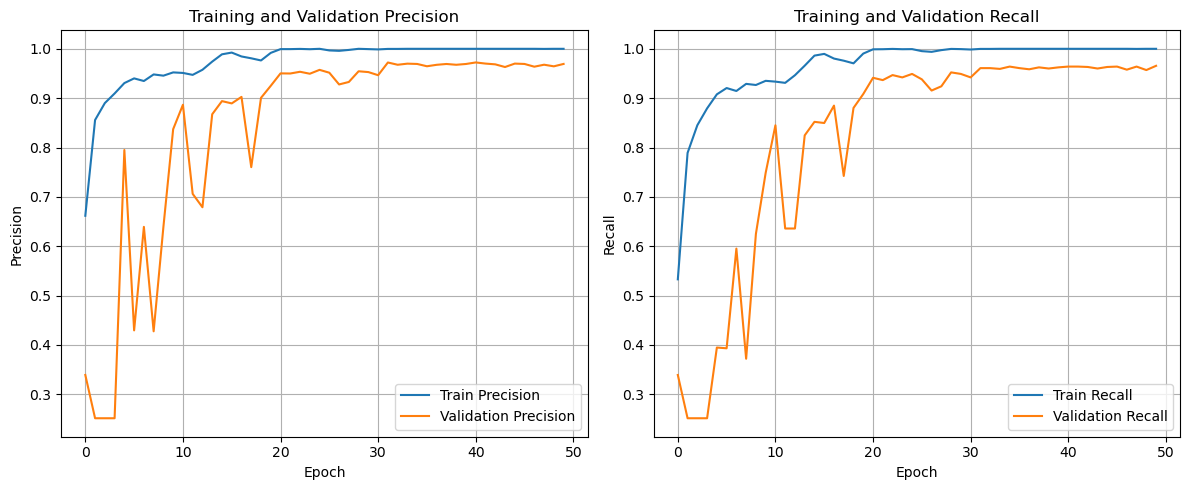

In [19]:
# Plotting training and validation precision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(hist.history['precision'], label='Train Precision')
plt.plot(hist.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Plotting training and validation recall
plt.subplot(1, 2, 2)
plt.plot(hist.history['recall'], label='Train Recall')
plt.plot(hist.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



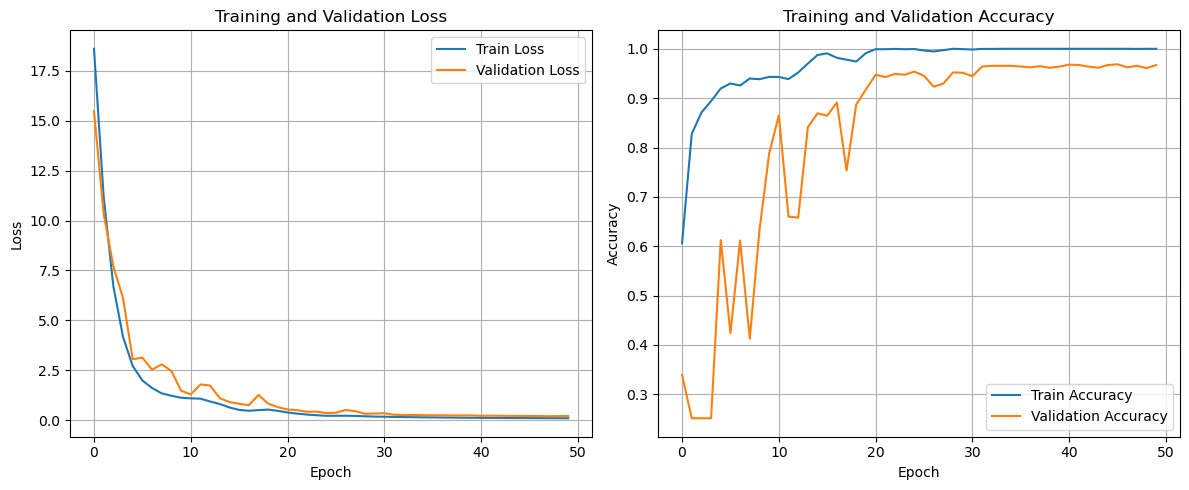

In [20]:
# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy (if needed)
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

25/25 [==============================] - 1s 20ms/step


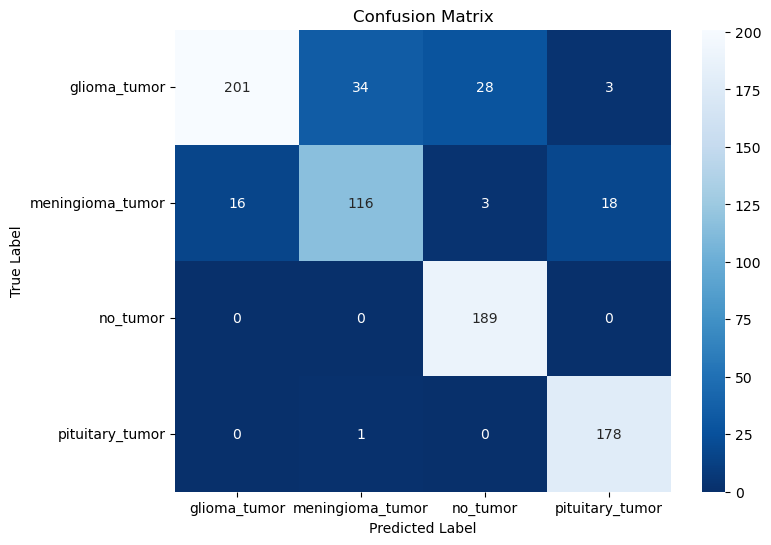

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict the classes for the test data
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability
y_true = np.argmax(Y_test, axis=1)  # Convert one-hot encoded labels back to class indices

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', 
            xticklabels=LABELS, yticklabels=LABELS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


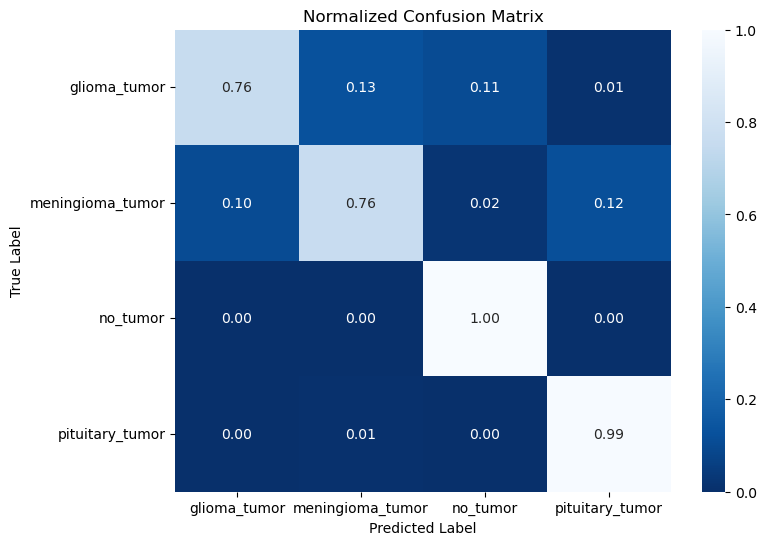

In [22]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cm is your confusion matrix and LABELS is defined
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues_r',  
                      xticklabels=LABELS, yticklabels=LABELS)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
my_model.save(f"../models/bt img proc 1")

INFO:tensorflow:Assets written to: ../models/bt img proc 1\assets


INFO:tensorflow:Assets written to: ../models/bt img proc 1\assets
